In [1]:
import os
import torch
import numpy as np
import segmentation_models_pytorch as smp

from scripts.evaluation import get_correct_mask
from scripts.plotting import show_images, plot_metric_per_epoch
from scripts.preprocessing import RoadDataset, split_data, get_patched_array
from scripts.training import train_model
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

In [2]:
import sys
sys.path.append('../')

In [3]:
ROOT_PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'training')

In [4]:
image_path_train, image_path_test, mask_path_train, mask_path_test = split_data(train_directory, 0.1)
# Get train and val dataset instances
train_dataset = RoadDataset(image_path_train, mask_path_train)
test_dataset = RoadDataset(image_path_test, mask_path_test)

In [5]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

SEED = 13
BATCH_SIZE = 4
K_FOLD = 2
N_CPU = os.cpu_count()
N_EPOCHS = 6

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE, 
    'num_workers': N_CPU, 
    'persistent_workers': True
}

In [6]:
model_ = smp.create_model("FPN", encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)

train_set, val_set = torch.utils.data.random_split(train_dataset, lengths=[0.9, 0.1])

train_loader = DataLoader(train_dataset, **LOADER_PARAMS)
valid_loader = DataLoader(train_dataset, **LOADER_PARAMS)

In [7]:
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model_, criterion_, optimizer_, (train_loader, valid_loader), N_EPOCHS
)

0 Loss: 0.4058 Acc: 0.5763
1 Loss: 0.3328 Acc: 0.6581
2 Loss: 0.2074 Acc: 0.7684
3 Loss: 0.1740 Acc: 0.8040
4 Loss: 0.2512 Acc: 0.7439
5 Loss: 0.1590 Acc: 0.8203


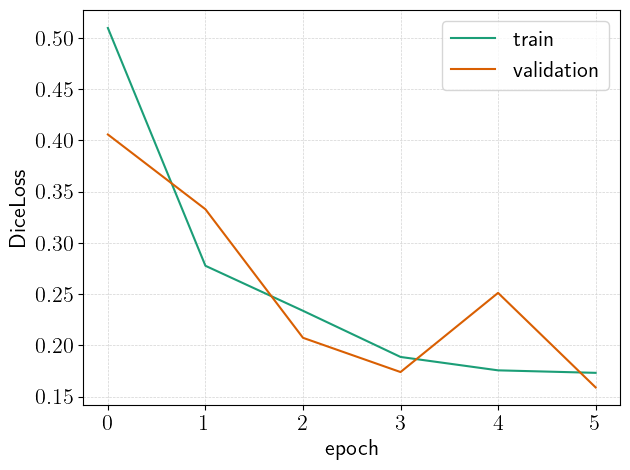

In [8]:
plot_metric_per_epoch(train_losses, valid_losses, 'DiceLoss')

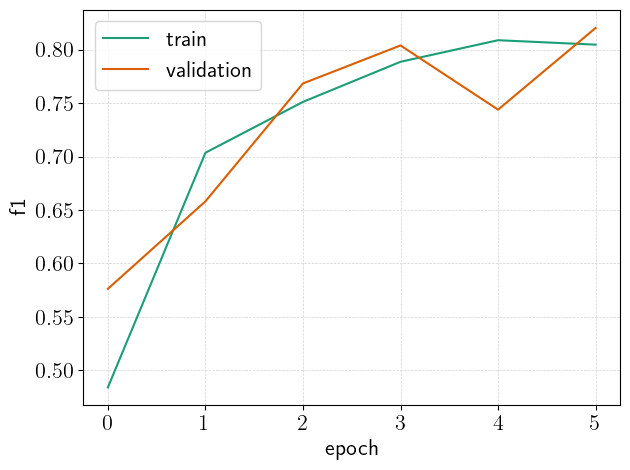

In [9]:
plot_metric_per_epoch(train_f1s, valid_f1s, 'f1')

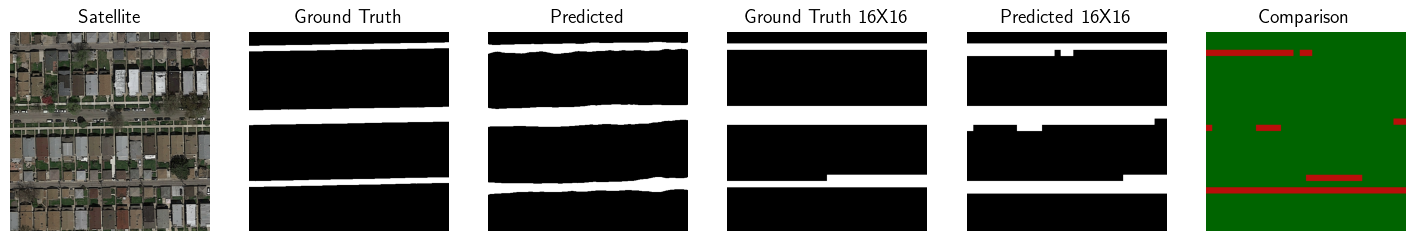

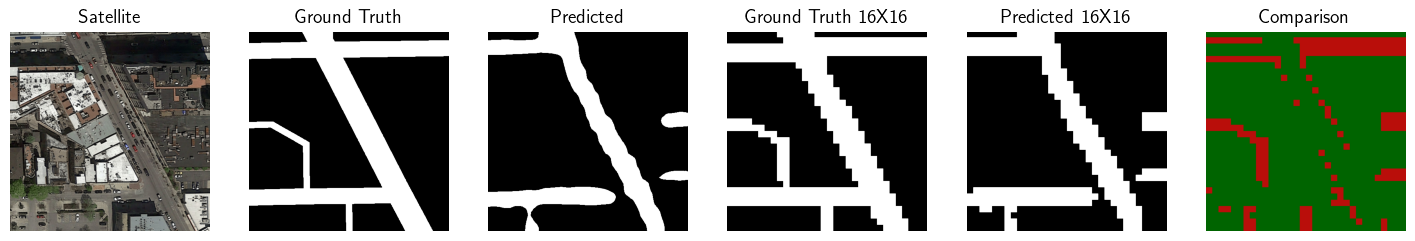

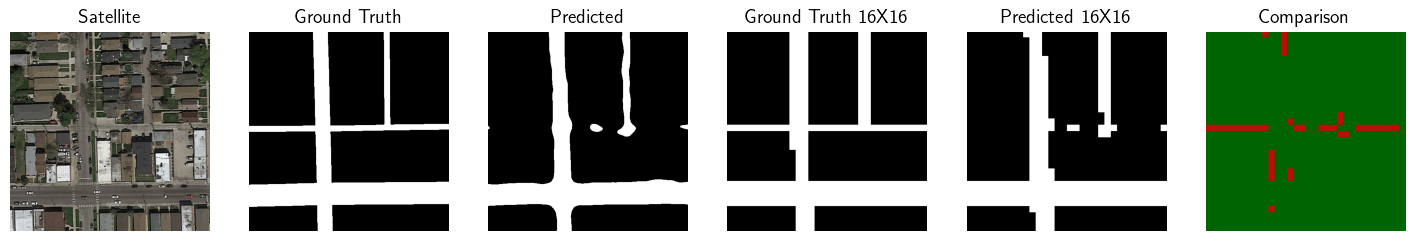

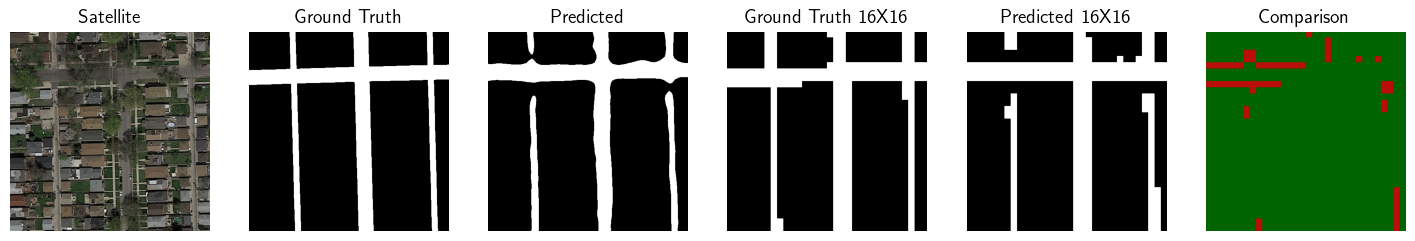

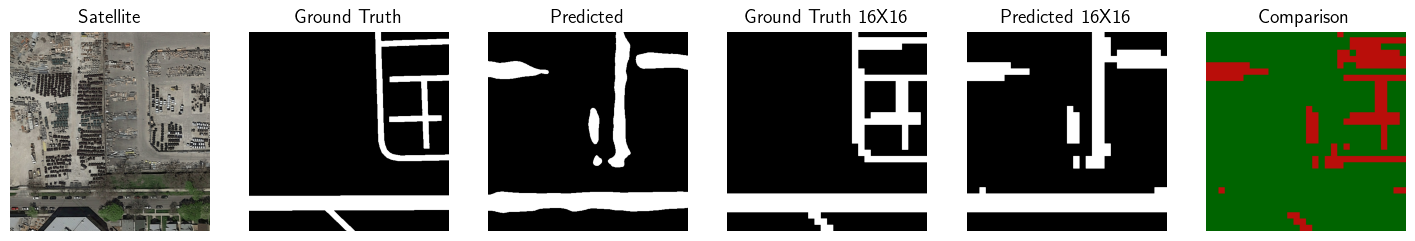

In [10]:
from scripts.evaluation import get_patched_f1

test_loader = DataLoader(test_dataset, batch_size=1)
test_images = iter(test_loader)
num_images = 5
model_.eval()

for _ in range(num_images):
    image, label = next(test_images)
    with torch.no_grad():
        logits = model_(image.float())

    predicted = np.where(logits.numpy().squeeze() >= 0.5, 1, 0)
        
    show_images(
        axis=False, 
        satellite=image, 
        ground_truth=label,
        predicted=predicted, 
        ground_truth_16x16=get_patched_array(label),
        predicted_16x16=get_patched_array(predicted),
        comparison=get_correct_mask(get_patched_array(label), get_patched_array(predicted))
    )

In [82]:
image, ground_truth = test_dataset[5]

In [ ]:
# TODO: need to work with this (cross-validation)
k_fold = KFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):
    
    model_ = smp.create_model("FPN", encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
    criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
    optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)
    
    train_loader = DataLoader(train_dataset, sampler=SubsetRandomSampler(train_idx), **LOADER_PARAMS)
    valid_loader = DataLoader(train_dataset, sampler=SubsetRandomSampler(val_idx), **LOADER_PARAMS)
    
    train_losses, valid_losses, train_f1s, valid_f1s = train_model(
        model_, criterion_, optimizer_, (train_loader, valid_loader), N_EPOCHS
    )